<a href="https://colab.research.google.com/github/enVives/Caltech101/blob/main/Caltech101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [863]:
from itertools import filterfalse
from collections import OrderedDict
import torch,torchvision
import numpy as np
import pandas as pd
import math
import cv2
import time
import os
import wandb
import pylab as pl
import scipy.io
import matplotlib.pyplot as plt


from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from torchvision import transforms,models
from torch import nn
from IPython.display import clear_output,display
from torch.utils.data import DataLoader, random_split,Subset,Dataset
from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from glob import glob

ROOT = './sample_data/'
CLASS_A = 'cougar_body'
CLASS_B = 'windsor_chair'

DOWNLOAD = False
wandb.login()
#471be466c8949671a46c67e7aad0d5a0ac8c9dad
#!rm -rf /content/sample_data/*
# torch.cuda.default_stream(torch.device('cuda'))

True

In [864]:
def find_mean_std(dataset):
  dataloader = DataLoader(dataset,batch_size = 1,shuffle=FALSE)
  mean = torch.zeros(3)
  std = torch.zeros(3)
  samples = 0

  for image,_ in dataloader:
    mean += image.mean(dim=[0, 2, 3])  # Mean for each channel [batchsize,channels,height,width]
    std += image.std(dim=[0, 2, 3])    # Std for each channel
    samples += 1

  mean /= samples
  std /= samples

  print(mean)
  print(std)

In [865]:
from pickle import NONE

class Formes(Dataset):
    def __init__(self, paths, labels= None, transforms = None,annotations = None,transform_mask = None):
        self.images = paths
        self.labels = labels
        self.transforms = transforms
        self.annotations = annotations
        self.transforms_mask = transform_mask

    def __len__(self):
        return len(self.labels)

    def __setmodel__(self,model):
        self.model = model

    def __getdist__(self):
      return pd.Series(self.labels).value_counts()

    def __showcontours__(self,index):
      path = self.images[index]
      image = cv2.imread(path, cv2.IMREAD_COLOR)
      image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      plt.imshow(image)

      mat_data = scipy.io.loadmat(self.annotations[index])
        #print("Keys in MAT file:", polygons_data.keys())

      polygons_data = mat_data['obj_contour']

      x_points = polygons_data[0]
      y_points = polygons_data[1]

      contour_points = np.array(list(zip(x_points,y_points)))

      plt.plot(contour_points[:, 0], contour_points[:, 1], '-r')  # Red contour line
      plt.scatter(contour_points[:, 0], contour_points[:, 1], c='blue')  # Optional: Mark contour points
      plt.show()

    def __getpureimage__(self,index):
      path = self.images[index]
      image = cv2.imread(path, cv2.IMREAD_COLOR)
      image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      return image

    def __getitem__(self, index):
      path = self.images[index]
      label = self.labels[index]

      seed = torch.random.seed()  # Create a unique seed for random operations

      if self.annotations != None:
        mat_data = scipy.io.loadmat(self.annotations[index])
        #print("Keys in MAT file:", polygons_data.keys())

        polygons_data = mat_data['obj_contour']
        boundingbox_data = mat_data['box_coord']

        x_points = polygons_data[0]
        y_points = polygons_data[1]

        contour_points = list(zip(x_points,y_points))
        contour = np.array(contour_points, dtype=np.int32)

        #print(contour_points)


      image = cv2.imread(path, cv2.IMREAD_COLOR)
      image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      if self.model == 3:
        mask = np.zeros(image.size, dtype=np.uint8)
        cv2.fillPoly(mask, [contour], color=255)  # White filled polygon
        mask = Image.fromarray(mask)  # Convert NumPy array to PIL Image

        torch.random.manual_seed(seed)  # Set seed for image
        mask_resized = self.transforms_mask(mask)
        mask_resized = (mask_resized > 0.5).float()

        torch.random.manual_seed(seed)  # Set seed for image
        image = self.transforms(image)

        return image, mask_resized

      image = self.transforms(image)

      return image, label

In [866]:
def get_labels(sett):
  labels = np.array([])
  frequency = np.zeros(101)
  for _,label in sett:
    labels = np.append(labels,label)
    frequency[label] += 1
  return labels.astype(int),frequency

In [867]:
#from pickle import FALSE
from sklearn.model_selection import train_test_split

TRAINING = 0.80
VAL = 0.10
TESTING = 0.10

#[0.5459, 0.5288, 0.5022]
#[0.2424, 0.2393, 0.2409]
mean = torch.tensor([0.485,0.456,0.406])
std = torch.tensor([0.229,0.224,0.225])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

transform_masks = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(p=0.1),
    # transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
])


transform2 = transforms.Compose([
    #transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),  # Ensure all images are RGB
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(p=0.1),
    # transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dataset = torchvision.datasets.Caltech101(root= ROOT,download=DOWNLOAD,transform=transform)
img_class_1 = sorted(glob('/content/sample_data/caltech101/101_ObjectCategories/cougar_body/*'))
img_class_2 = sorted(glob('/content/sample_data/caltech101/101_ObjectCategories/windsor_chair/*'))

img_annotations_class_1 = sorted(glob('/content/sample_data/caltech101/Annotations/cougar_body/*'))
img_annotations_class_2 = sorted(glob('/content/sample_data/caltech101/Annotations/windsor_chair/*'))


img_files = img_class_1 +  img_class_2
img_annotations = img_annotations_class_1 + img_annotations_class_2

img_files_duplicated = img_files + img_files  # Duplicate image paths
img_annotations_duplicated = img_annotations + img_annotations  # Duplicate annotation paths

img_files = img_files_duplicated
img_annotations = img_annotations_duplicated

labels = []
for img_path in img_files:
  label = img_path.split(os.path.sep)[-2]
  labels.append(label)

lb = LabelEncoder()
labels = lb.fit_transform(labels)

weights = 1.0 / pd.Series(labels).value_counts()
weights = weights / weights.sum()
weights = torch.tensor(weights,dtype=torch.float32)

X_train, X_test, y_train, y_test, annotations_train, annotations_test = train_test_split(
    img_files, labels, img_annotations, test_size=TESTING, random_state=42, stratify=labels
)

# Split the training set further into training and validation sets
X_train, X_val, y_train, y_val, annotations_train, annotations_val = train_test_split(
    X_train, y_train, annotations_train, test_size=VAL/(TRAINING+VAL), random_state=42, stratify=y_train
)

training = Formes(X_train,y_train,transform2,annotations_train,transform_masks)
testing = Formes(X_test,y_test,transform,annotations_test,transform_masks)
validation = Formes(X_val,y_val,transform,annotations_val,transform_masks)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#training,validation,testing = random_split(dataset,[train_size,validation_size,len(dataset)-train_size-validation_size])

In [868]:
print(f"LONGITUD SET DE TRAINING: {training.__len__()}")
with open("training.txt", "w") as file:
    for item in training.__getdist__()/training.__len__():
        file.write(f"{item}\n")
print(f"LONGITUD SET DE VALIDATION: {validation.__len__()}")
with open("valid.txt", "w") as file:
    for item in validation.__getdist__()/validation.__len__():
        file.write(f"{item}\n")
print(f"LONGITUD SET DE TESTING: {testing.__len__()}")

LONGITUD SET DE TRAINING: 164
LONGITUD SET DE VALIDATION: 21
LONGITUD SET DE TESTING: 21


Ara ja sabem que hem de predir si una imatge pertany a les classes 25 o 99

In [869]:
def veure_imatges(train_data,std,mean):
  for i in range(len(train_data)):
    imatge,label = train_data[i]

    print(imatge.ndimension())
    print(imatge.shape)

    imatge = imatge * (std[:, None, None]*255) + (mean[:, None, None]*255)
    # Convert the tensor back to a NumPy array
    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    cv2_imshow(img_numpy)
    time.sleep(5)
    clear_output(wait=True)

In [870]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features

        ## CODER
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        ## DECODER

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2,
                                          stride=2)  # Empra aquesta capa com exemple
        self.decoder4 = UNet._block(features * 16, features * 8, name="dec4")

        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNet._block(features * 8, features * 4, name="dec3")

        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block(features * 4, features * 2, name="dec2")

        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.final = nn.Conv2d(
            in_channels=features,
            out_channels=out_channels,
            kernel_size=1,
            padding=0,
            bias=False,
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec1 = self.upconv4(bottleneck)
        dec1 = torch.cat((dec1, enc4), dim=1)
        dec2 = self.decoder4(dec1)

        dec2 = self.upconv3(dec2)
        dec2 = torch.cat((dec2, enc3), dim=1)
        dec3 = self.decoder3(dec2)

        dec3 = self.upconv2(dec3)
        dec3 = torch.cat((dec3, enc2), dim=1)
        dec4 = self.decoder2(dec3)

        dec4 = self.upconv1(dec4)
        dec4 = torch.cat((dec4, enc1), dim=1)
        dec5 = self.decoder1(dec4)
        return torch.sigmoid(self.final(dec5))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (name + "conv1",
                     nn.Conv2d(
                         in_channels=in_channels,
                         out_channels=features,
                         kernel_size=3,
                         padding=1,
                         bias=False,
                     ),
                     ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (name + "conv2",
                     nn.Conv2d(
                         in_channels=features,
                         out_channels=features,
                         kernel_size=3,
                         padding=1,
                         bias=False,
                     ),
                     ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [871]:
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 0.0

    def forward(self, y_pred, y_true):
        # print(y_pred)
        # print(y_true)
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
                y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

In [872]:
def pick_algorithm(number):
  if number == 0:
    alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1) #fine tuning
    # Modify the classifier
    alexnet.classifier[6] = nn.Linear(in_features=4096, out_features=1)

    # alexnetmulticlass.classifier = nn.Sequential(
    # torch.nn.Dropout(p=0.1),
    # torch.nn.Linear(9216, 2048),
    # nn.ReLU(inplace=True),
    # torch.nn.Linear(2048, 1024),
    # nn.ReLU(inplace=True),
    # torch.nn.Linear(1024, 512),
    # nn.ReLU(inplace=True),
    # torch.nn.Linear(512, 1),  # Ja que tenim 10 classes.
    # )

    loss_fn = nn.BCEWithLogitsLoss()
    #loss_fn = nn.CrossEntropyLoss(weight=weights.to(device))
    return alexnet,loss_fn
  elif number == 1:
    vgg = models.vgg16(weights = models.VGG16_Weights.IMAGENET1K_V1)
    vgg.classifier[6] = nn.Linear(in_features=4096, out_features=1)

    loss_fn = nn.BCEWithLogitsLoss()
    return vgg,loss_fn
  elif number == 2:
    resnet = models.resnet18(weights="IMAGENET1K_V1")
    resnet.classifier[6] = nn.Linear(in_features=4096, out_features=1)
    loss_fn = nn.BCEWithLogitsLoss()

    return resnet,loss_fn
  elif number == 3:
    unet = UNet(3,1)
    loss_fn = DiceLoss()
    return unet,loss_fn

In [873]:
BATCH_SIZE = 8
EPOCHS = 50
PATIENCE = 30

architectures = {'alexnet': 0,'vgg': 1,'resnet': 2,'unet':3}

MODEL = architectures['unet']

training.__setmodel__(MODEL)
validation.__setmodel__(MODEL)
testing.__setmodel__(MODEL)

train_loader = torch.utils.data.DataLoader(training, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation, batch_size=validation.__len__(), shuffle=True)
testing_loader = torch.utils.data.DataLoader(testing, batch_size=testing.__len__(), shuffle=True)

model,loss_fn = pick_algorithm(MODEL)
model.to(device)

learning_rate = 0.00015
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

wandb.init(
        project="caltech101-proves",
        config={
            "epochs": 20,
            "batch_size": BATCH_SIZE,
            "lr": learning_rate,
            "tsize":TRAINING,
            "vsize":VAL,
            "weights": True
            })


config = wandb.config

test_target = None
test_output = None

#veure_imatges(training,std,mean)

In [874]:
img, target= next(iter(train_loader))
print(img.shape)

torch.Size([16, 3, 224, 224])


In [875]:
def fit(model,loss_fn,dataloader,optimizer,epoch,config):

  batch_num = 1
  train_loss = 0
  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0

  n_steps_per_epoch = math.ceil(len(dataloader) / config.batch_size)
  example_ct = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):

        model.train()

        optimizer.zero_grad()
        #extreu_classes(target.to(device))

        output = model(input_img.to(device))

        #print(target.shape)
        # print(target)
        #print(output.shape)
        # print(output)



        if MODEL != architectures['unet']:
          target = target.float().unsqueeze(1)
        else:
          target = target.to(dtype=torch.float32)


        target = target.to(device)
        loss = loss_fn(output, target)


        model.zero_grad()
        loss.backward()

        with torch.no_grad():
          optimizer.step()


        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        model.eval()

        # print("Target unique values and counts:", torch.unique(target, return_counts=True))
        # print("Output unique values and counts:", torch.unique((output > 0.5).int(), return_counts=True))


        if MODEL == architectures['unet']:
            output = (output.view(-1).cpu().detach().numpy() > 0.5).astype(int)
            target = target.view(-1).cpu().detach().numpy()
        else:
          output = torch.sigmoid(output)
          output = (output.cpu().detach().numpy() > 0.5).astype(int)
          target = target.cpu().detach().numpy()


        y_class_predict = output



        a= accuracy_score(target,y_class_predict)
        b= f1_score(target,y_class_predict,zero_division=1)
        c= recall_score(target,y_class_predict,zero_division=1)
        d= precision_score(target,y_class_predict,zero_division=1)
        e = loss.item()



        train_acc += a
        train_f1 += b
        train_recall += c
        train_precision += d
        train_loss += e

        example_ct += len(input_img)

  return train_acc,train_f1,train_recall,train_precision,train_loss

In [876]:

def validate(model,data_loader,loss_fn,config):

  val_acc = 0
  val_recall = 0
  val_f1 = 0
  val_loss = 0
  val_precision = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):


            output = model(input_img.to(device))
            target = target.to(device)

            if MODEL != architectures['unet']:
              target = target.float().unsqueeze(1)
            else:
              target = target.to(dtype=torch.float32)

            loss = loss_fn(output, target)



            if MODEL == architectures['unet']:
              output = (output.view(-1).cpu().detach().numpy() > 0.5).astype(int)
              target = target.view(-1).cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)
              output = (output.cpu().detach().numpy() > 0.5).astype(int)
              target = target.cpu().detach().numpy()


            # with open("outputtarget.txt", "w") as file:
            #   file.write(f"OUTPUT\n")
            #   np.savetxt(file, output, fmt="%d")  # Save output as integers
            #   file.write(f"TARGET\n")
            #   np.savetxt(file, target, fmt="%d")  # Save output as integers

            y_class_predict = output

            val_acc  += accuracy_score(target,y_class_predict)
            val_f1 += f1_score(target,y_class_predict,zero_division=1)
            val_recall += recall_score(target,y_class_predict,zero_division=1)
            val_precision += precision_score(target,y_class_predict,zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [877]:
def test(model,data_loader,loss_fn,config):

  global test_target
  global test_output


  test_acc = 0
  test_recall = 0
  test_f1 = 0
  test_loss = 0
  test_precision = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):


            output = model(input_img.to(device))
            target = target.to(device)

            if MODEL != architectures['unet']:
              target = target.float().unsqueeze(1)
            else:
              target = target.to(dtype=torch.float32)

            loss = loss_fn(output, target)



            if MODEL == architectures['unet']:

              output = (output.view(-1).cpu().detach().numpy() > 0.5).astype(int)
              target = target.view(-1).cpu().detach().numpy()

              test_output = output
              test_target = target

            else:
              output = torch.sigmoid(output)
              output = (output.cpu().detach().numpy() > 0.5).astype(int)
              target = target.cpu().detach().numpy()


            # with open("outputtarget.txt", "w") as file:
            #   file.write(f"OUTPUT\n")
            #   np.savetxt(file, output, fmt="%d")  # Save output as integers
            #   file.write(f"TARGET\n")
            #   np.savetxt(file, target, fmt="%d")  # Save output as integers

            y_class_predict = output

            test_acc  += accuracy_score(target,y_class_predict)
            test_f1 += f1_score(target,y_class_predict,zero_division=1)
            test_recall += recall_score(target,y_class_predict,zero_division=1)
            test_precision += precision_score(target,y_class_predict,zero_division=1)

            test_loss += loss.item()

  return test_acc,test_f1,test_recall,test_precision,test_loss

In [878]:
#def executa():
t_loss = np.zeros(EPOCHS)
v_loss = np.zeros(EPOCHS)
acc_t = np.zeros(EPOCHS) #accuracy
acc_v = np.zeros(EPOCHS)
f1_t = np.zeros(EPOCHS) #f1
f1_v = np.zeros(EPOCHS)
recall_t = np.zeros(EPOCHS) #recall
recall_v = np.zeros(EPOCHS)
precision_t = np.zeros(EPOCHS)
precision_v = np.zeros(EPOCHS) #precisió

epochs_without_improvement = 0
best_val_loss = float('inf')
best_val_acc = 0
pbar = tqdm(range(1, EPOCHS + 1))  # tdqm permet tenir text dinàmic

for epoch in pbar:


  train_acc,train_f1,train_recall,train_precision,train_loss = fit(model,loss_fn,train_loader,optimizer,epoch,config)

  val_acc,val_f1,val_recall,val_precision,val_loss = validate(model,validation_loader,loss_fn,config)

  test_acc,test_f1,test_recall,test_precision,test_loss = test(model,testing_loader,loss_fn,config)

  training_metrics = {"train/train_loss": train_loss/len(train_loader),
                  "train/train_acc":train_acc/len(train_loader),
                  "train/train_f1":train_f1/len(train_loader),
                  "train/train_recall":train_recall/len(train_loader),
                  "train/train_precision":train_precision/len(train_loader)}

  val_metrics = {"val/val_loss": val_loss/len(validation_loader),
                "val/val_acc":val_acc/len(validation_loader),
                "val/val_f1":val_f1/len(validation_loader),
                "val/val_recall": val_recall/len(validation_loader),
                "val/val_precision": val_precision/len(validation_loader)}

  # testing_metrics = {"test/test_loss": test_loss/len(testing_loader),
  #                    "test/test_acc": test_acc/len(testing_loader),
  #                    "test/test_f1":test_f1/len(testing_loader),
  #                    "test/test_recall": test_recall/len(testing_loader),
  #                     "test/test_precision": test_precision/len(testing_loader)}

  #Early Stopping:

  if val_acc >= best_val_acc:
      best_val_acc = val_acc
      epochs_without_improvement = 0
  else:
    # print("Early stopping triggered!")
    # break
      epochs_without_improvement += 1

  #Saving the results

  wandb.log({**training_metrics, **val_metrics})

  torch.save(model, "my_model.pt")
  wandb.log_model("./my_model.pt", "alexnet", aliases=[f"epoch-{epoch+1}"])

  train_loss /= len(train_loader)
  t_loss[epoch - 1] = train_loss

  train_acc /= len(train_loader)
  acc_t[epoch - 1] = train_acc

  train_f1 /= len(train_loader)
  f1_t[epoch - 1] = train_f1

  train_recall /= len(train_loader)
  recall_t[epoch - 1] = train_recall

  train_precision /= len(train_loader)
  precision_t[epoch-1] = train_precision

  print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
  print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
  print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
  print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")
  print(f"Precision train epoch: {epoch}  train_recall: {train_precision}")

  val_loss /= len(validation_loader)
  v_loss[epoch - 1] = val_loss

  val_acc /= len(validation_loader)
  acc_v[epoch - 1] = val_acc

  val_f1 /= len(validation_loader)
  f1_v[epoch - 1] = val_f1

  val_recall /= len(validation_loader)
  recall_v[epoch - 1] = val_recall

  val_precision /= len(validation_loader)
  precision_v[epoch-1] = val_precision

  print()
  print()
  print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
  print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
  print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
  print(f"Recall val epoch: {epoch}  val_reall: {val_recall}")
  print(f"Precision val epoch: {epoch}  val_reall: {val_precision}")

  test_loss /= len(testing_loader)

  test_acc /= len(testing_loader)

  test_f1 /= len(testing_loader)

  test_recall /= len(testing_loader)

  test_precision /= len(testing_loader)

  print()
  print()
  print(f"Pèrdua testing epoch: {epoch}  val_loss: {test_loss}")
  print(f"Accuracy test epoch: {epoch}  val_acc: {test_acc}")
  print(f"F1 test epoch: {epoch}  val_f1: {test_f1}")
  print(f"Recall test epoch: {epoch}  val_reall: {test_recall}")
  print(f"Precision test epoch: {epoch}  val_reall: {test_precision}")

  # if epochs_without_improvement >= PATIENCE:
  #     print("Early stopping triggered!")
  #     break

  # if val_acc > 0.9:
  #   print("Early stopping triggered!")
  #   break

wandb.finish()

  0%|          | 0/20 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.5957334475083784
Accuracy train epoch: 1  train_acc: 0.41894803020640076
F1 train epoch: 1  train_f1: 0.4555981847919425
Recall train epoch: 1  train_recall: 0.8216108945342132
Precision train epoch: 1  train_recall: 0.31538959866019184


Pèrdua validació epoch: 1  val_loss: 0.6289724707603455
Accuracy val epoch: 1  val_acc: 0.3462402818270165
F1 val epoch: 1  val_f1: 0.4307577127312332
Recall val epoch: 1  val_reall: 0.8686605765096802
Precision val epoch: 1  val_reall: 0.2863865860157456


Pèrdua testing epoch: 1  val_loss: 0.6057713031768799
Accuracy test epoch: 1  val_acc: 0.391092876882896
F1 test epoch: 1  val_f1: 0.4619848273051486
Recall test epoch: 1  val_reall: 0.8346371998884997
Precision test epoch: 1  val_reall: 0.319384621092577


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.5605364658615806
Accuracy train epoch: 2  train_acc: 0.4794215271335807
F1 train epoch: 2  train_f1: 0.4898640311259607
Recall train epoch: 2  train_recall: 0.842587521379065
Precision train epoch: 2  train_recall: 0.34600941819751524


Pèrdua validació epoch: 2  val_loss: 0.6135237812995911
Accuracy val epoch: 2  val_acc: 0.3605802812196307
F1 val epoch: 2  val_f1: 0.4370427435553788
Recall val epoch: 2  val_reall: 0.8647559277984069
Precision val epoch: 2  val_reall: 0.2924134121811622


Pèrdua testing epoch: 2  val_loss: 0.5930041074752808
Accuracy test epoch: 2  val_acc: 0.3945635173712342
F1 test epoch: 2  val_f1: 0.4652249430810345
Recall test epoch: 2  val_reall: 0.8423383632792698
Precision test epoch: 2  val_reall: 0.32135490916586856


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.48596530610864813
Accuracy train epoch: 3  train_acc: 0.6507147114882884
F1 train epoch: 3  train_f1: 0.5960885081344265
Recall train epoch: 3  train_recall: 0.8618288330870825
Precision train epoch: 3  train_recall: 0.45740466950150865


Pèrdua validació epoch: 3  val_loss: 0.5211031436920166
Accuracy val epoch: 3  val_acc: 0.5241198599975705
F1 val epoch: 3  val_f1: 0.5235053029590331
Recall val epoch: 3  val_reall: 0.9167310098777923
Precision val epoch: 3  val_reall: 0.36635832230520105


Pèrdua testing epoch: 3  val_loss: 0.4984971880912781
Accuracy test epoch: 3  val_acc: 0.5434688942541303
F1 test epoch: 3  val_f1: 0.5489071163795165
Recall test epoch: 3  val_reall: 0.8893578617269545
Precision test epoch: 3  val_reall: 0.39695189682508464


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.43272940679029986
Accuracy train epoch: 4  train_acc: 0.7626480923512869
F1 train epoch: 4  train_f1: 0.6763931868606646
Recall train epoch: 4  train_recall: 0.827235394722461
Precision train epoch: 4  train_recall: 0.5739081913616161


Pèrdua validació epoch: 4  val_loss: 0.4351534843444824
Accuracy val epoch: 4  val_acc: 0.7063450938411079
F1 val epoch: 4  val_f1: 0.6299914261012437
Recall val epoch: 4  val_reall: 0.8751486720841999
Precision val epoch: 4  val_reall: 0.49213000760376713


Pèrdua testing epoch: 4  val_loss: 0.40974390506744385
Accuracy test epoch: 4  val_acc: 0.7382755557580175
F1 test epoch: 4  val_f1: 0.6617258509659614
Recall test epoch: 4  val_reall: 0.8191566576066326
Precision test epoch: 4  val_reall: 0.555052318582614


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.4102110808545893
Accuracy train epoch: 5  train_acc: 0.7842475169222518
F1 train epoch: 5  train_f1: 0.6976146214258069
Recall train epoch: 5  train_recall: 0.8376670537398927
Precision train epoch: 5  train_recall: 0.5985934962945958


Pèrdua validació epoch: 5  val_loss: 0.3853301405906677
Accuracy val epoch: 5  val_acc: 0.7939548029033042
F1 val epoch: 5  val_f1: 0.6940985015533967
Recall val epoch: 5  val_reall: 0.8154061587558016
Precision val epoch: 5  val_reall: 0.6042103610598022


Pèrdua testing epoch: 5  val_loss: 0.39644038677215576
Accuracy test epoch: 5  val_acc: 0.765347880223518
F1 test epoch: 5  val_f1: 0.6674109785100132
Recall test epoch: 5  val_reall: 0.7536637826277159
Precision test epoch: 5  val_reall: 0.5988731387960835


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.40605065497485077
Accuracy train epoch: 6  train_acc: 0.7863182959618505
F1 train epoch: 6  train_f1: 0.6963944283155036
Recall train epoch: 6  train_recall: 0.8300187016472834
Precision train epoch: 6  train_recall: 0.6013340127600212


Pèrdua validació epoch: 6  val_loss: 0.3721604347229004
Accuracy val epoch: 6  val_acc: 0.8280984268707483
F1 val epoch: 6  val_f1: 0.7216368732941553
Recall val epoch: 6  val_reall: 0.7800328909118092
Precision val epoch: 6  val_reall: 0.6713753434998814


Pèrdua testing epoch: 6  val_loss: 0.3773834705352783
Accuracy test epoch: 6  val_acc: 0.7950129828717201
F1 test epoch: 6  val_f1: 0.6911830306080432
Recall test epoch: 6  val_reall: 0.7346938155203175
Precision test epoch: 6  val_reall: 0.6525377743822602


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.38463526422327216
Accuracy train epoch: 7  train_acc: 0.8063405449182515
F1 train epoch: 7  train_f1: 0.7269941325923976
Recall train epoch: 7  train_recall: 0.8690647058931918
Precision train epoch: 7  train_recall: 0.6266854722667993


Pèrdua validació epoch: 7  val_loss: 0.3921842575073242
Accuracy val epoch: 7  val_acc: 0.7940743819849369
F1 val epoch: 7  val_f1: 0.7010376322529889
Recall val epoch: 7  val_reall: 0.8488045429370275
Precision val epoch: 7  val_reall: 0.5970910814914955


Pèrdua testing epoch: 7  val_loss: 0.39592576026916504
Accuracy test epoch: 7  val_acc: 0.7696859435738581
F1 test epoch: 7  val_f1: 0.6762358233686118
Recall test epoch: 7  val_reall: 0.7700043446425696
Precision test epoch: 7  val_reall: 0.6028257456828885


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.3681601719422774
Accuracy train epoch: 8  train_acc: 0.8189454936804268
F1 train epoch: 8  train_f1: 0.744531251502519
Recall train epoch: 8  train_recall: 0.8832229998764397
Precision train epoch: 8  train_recall: 0.6443171329255382


Pèrdua validació epoch: 8  val_loss: 0.4008626341819763
Accuracy val epoch: 8  val_acc: 0.7705638058794947
F1 val epoch: 8  val_f1: 0.6939797468354431
Recall val epoch: 8  val_reall: 0.9066350036877668
Precision val epoch: 8  val_reall: 0.5621297285547596


Pèrdua testing epoch: 8  val_loss: 0.3982927203178406
Accuracy test epoch: 8  val_acc: 0.7570228984450923
F1 test epoch: 8  val_f1: 0.6860003630280463
Recall test epoch: 8  val_reall: 0.8488404209146121
Precision test epoch: 8  val_reall: 0.5755817662809148


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.3664871400052851
Accuracy train epoch: 9  train_acc: 0.8254987897147497
F1 train epoch: 9  train_f1: 0.7490614183558336
Recall train epoch: 9  train_recall: 0.883520959810551
Precision train epoch: 9  train_recall: 0.6519294891313728


Pèrdua validació epoch: 9  val_loss: 0.3832697868347168
Accuracy val epoch: 9  val_acc: 0.7991479515913509
F1 val epoch: 9  val_f1: 0.7146391747017112
Recall val epoch: 9  val_reall: 0.8769831026745826
Precision val epoch: 9  val_reall: 0.6030118165331343


Pèrdua testing epoch: 9  val_loss: 0.3912327289581299
Accuracy test epoch: 9  val_acc: 0.7774358069120505
F1 test epoch: 9  val_f1: 0.6909042022477537
Recall test epoch: 9  val_reall: 0.7974800629223603
Precision test epoch: 9  val_reall: 0.6094560218019133


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.36132539402354846
Accuracy train epoch: 10  train_acc: 0.823157598888277
F1 train epoch: 10  train_f1: 0.7481811037741175
Recall train epoch: 10  train_recall: 0.8847021109533095
Precision train epoch: 10  train_recall: 0.6491552281690317


Pèrdua validació epoch: 10  val_loss: 0.40723294019699097
Accuracy val epoch: 10  val_acc: 0.7886790877065112
F1 val epoch: 10  val_f1: 0.6788862225708946
Recall val epoch: 10  val_reall: 0.7885571472602281
Precision val epoch: 10  val_reall: 0.5959962727760728


Pèrdua testing epoch: 10  val_loss: 0.3838299512863159
Accuracy test epoch: 10  val_acc: 0.7968579172740525
F1 test epoch: 10  val_f1: 0.7010683611479646
Recall test epoch: 10  val_reall: 0.7662414179434813
Precision test epoch: 10  val_reall: 0.6461128972886425


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.34829921614040027
Accuracy train epoch: 11  train_acc: 0.8350117812572472
F1 train epoch: 11  train_f1: 0.7645636403007536
Recall train epoch: 11  train_recall: 0.9028597107437979
Precision train epoch: 11  train_recall: 0.6635306072122095


Pèrdua validació epoch: 11  val_loss: 0.39867717027664185
Accuracy val epoch: 11  val_acc: 0.7851059508624878
F1 val epoch: 11  val_f1: 0.6933734164787769
Recall val epoch: 11  val_reall: 0.8521822490879557
Precision val epoch: 11  val_reall: 0.5844567061074192


Pèrdua testing epoch: 11  val_loss: 0.38708561658859253
Accuracy test epoch: 11  val_acc: 0.7777537354227405
F1 test epoch: 11  val_f1: 0.694517277814738
Recall test epoch: 11  val_reall: 0.8040139536990893
Precision test epoch: 11  val_reall: 0.6112699342127923


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.33236419612711127
Accuracy train epoch: 12  train_acc: 0.8540048121521336
F1 train epoch: 12  train_f1: 0.7887520040933882
Recall train epoch: 12  train_recall: 0.9146690492545084
Precision train epoch: 12  train_recall: 0.6950448528953281


Pèrdua validació epoch: 12  val_loss: 0.3874959349632263
Accuracy val epoch: 12  val_acc: 0.7998132288629738
F1 val epoch: 12  val_f1: 0.7096976636645894
Recall val epoch: 12  val_reall: 0.8560121644323154
Precision val epoch: 12  val_reall: 0.60609964222077


Pèrdua testing epoch: 12  val_loss: 0.3742263913154602
Accuracy test epoch: 12  val_acc: 0.7896537521258503
F1 test epoch: 12  val_f1: 0.7117993475075125
Recall test epoch: 12  val_reall: 0.8253847151313746
Precision test epoch: 12  val_reall: 0.6256943777689385


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.33835124427622015
Accuracy train epoch: 13  train_acc: 0.8426370992288962
F1 train epoch: 13  train_f1: 0.773182279523036
Recall train epoch: 13  train_recall: 0.9064056095490728
Precision train epoch: 13  train_recall: 0.6769244221307186


Pèrdua validació epoch: 13  val_loss: 0.3788411021232605
Accuracy val epoch: 13  val_acc: 0.8184998329689018
F1 val epoch: 13  val_f1: 0.7232233825776873
Recall val epoch: 13  val_reall: 0.8300335514732751
Precision val epoch: 13  val_reall: 0.6407682089314931


Pèrdua testing epoch: 13  val_loss: 0.3735847473144531
Accuracy test epoch: 13  val_acc: 0.79948675898931
F1 test epoch: 13  val_f1: 0.715213845718368
Recall test epoch: 13  val_reall: 0.8053529309983699
Precision test epoch: 13  val_reall: 0.6432213313679045


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.3278954733501781
Accuracy train epoch: 14  train_acc: 0.84832763671875
F1 train epoch: 14  train_f1: 0.7831021992714525
Recall train epoch: 14  train_recall: 0.9151054525998927
Precision train epoch: 14  train_recall: 0.6851300075805721


Pèrdua validació epoch: 14  val_loss: 0.34404492378234863
Accuracy val epoch: 14  val_acc: 0.8324089680515063
F1 val epoch: 14  val_f1: 0.7512641735333474
Recall val epoch: 14  val_reall: 0.8785865128338599
Precision val epoch: 14  val_reall: 0.6561733392057911


Pèrdua testing epoch: 14  val_loss: 0.35582298040390015
Accuracy test epoch: 14  val_acc: 0.8094649690233237
F1 test epoch: 14  val_f1: 0.7248514384703096
Recall test epoch: 14  val_reall: 0.7993452870339024
Precision test epoch: 14  val_reall: 0.663058631203113


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.3278732895851135
Accuracy train epoch: 15  train_acc: 0.8510446636928919
F1 train epoch: 15  train_f1: 0.7834057827616526
Recall train epoch: 15  train_recall: 0.9247987221370397
Precision train epoch: 15  train_recall: 0.6813960208927576


Pèrdua validació epoch: 15  val_loss: 0.36249035596847534
Accuracy val epoch: 15  val_acc: 0.8257827684645287
F1 val epoch: 15  val_f1: 0.7401192009853194
Recall val epoch: 15  val_reall: 0.8689173062795638
Precision val epoch: 15  val_reall: 0.644574970964425


Pèrdua testing epoch: 15  val_loss: 0.35864007472991943
Accuracy test epoch: 15  val_acc: 0.8157447688896987
F1 test epoch: 15  val_f1: 0.734239419827224
Recall test epoch: 15  val_reall: 0.8110635312333672
Precision test epoch: 15  val_reall: 0.6707096574128026


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.31438317082144995
Accuracy train epoch: 16  train_acc: 0.8662263378362707
F1 train epoch: 16  train_f1: 0.8033435368873818
Recall train epoch: 16  train_recall: 0.9258894885492441
Precision train epoch: 16  train_recall: 0.7104651589282424


Pèrdua validació epoch: 16  val_loss: 0.3923124670982361
Accuracy val epoch: 16  val_acc: 0.7740714589407192
F1 val epoch: 16  val_f1: 0.6822214331671869
Recall val epoch: 16  val_reall: 0.8576688393198768
Precision val epoch: 16  val_reall: 0.5663642085852586


Pèrdua testing epoch: 16  val_loss: 0.3663135766983032
Accuracy test epoch: 16  val_acc: 0.777927409803207
F1 test epoch: 16  val_f1: 0.7055215418787715
Recall test epoch: 16  val_reall: 0.8519719645484055
Precision test epoch: 16  val_reall: 0.6020343511532357


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.30565395138480445
Accuracy train epoch: 17  train_acc: 0.8677017126985738
F1 train epoch: 17  train_f1: 0.8071708885782226
Recall train epoch: 17  train_recall: 0.9227678142944835
Precision train epoch: 17  train_recall: 0.7204017500295594


Pèrdua validació epoch: 17  val_loss: 0.3686171770095825
Accuracy val epoch: 17  val_acc: 0.8263417532191448
F1 val epoch: 17  val_f1: 0.7294715630456349
Recall val epoch: 17  val_reall: 0.8191193364809318
Precision val epoch: 17  val_reall: 0.6575108806025441


Pèrdua testing epoch: 17  val_loss: 0.3677704930305481
Accuracy test epoch: 17  val_acc: 0.816319887329932
F1 test epoch: 17  val_f1: 0.7201125663952289
Recall test epoch: 17  val_reall: 0.7555609504445726
Precision test epoch: 17  val_reall: 0.6878413583333564


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.3003071980042891
Accuracy train epoch: 18  train_acc: 0.8748101002652482
F1 train epoch: 18  train_f1: 0.8157862216943582
Recall train epoch: 18  train_recall: 0.9317771047227211
Precision train epoch: 18  train_recall: 0.7271543882538803


Pèrdua validació epoch: 18  val_loss: 0.37430888414382935
Accuracy val epoch: 18  val_acc: 0.7935989127793974
F1 val epoch: 18  val_f1: 0.70467316116662
Recall val epoch: 18  val_reall: 0.8585197832085922
Precision val epoch: 18  val_reall: 0.5975858606330839


Pèrdua testing epoch: 18  val_loss: 0.356528639793396
Accuracy test epoch: 18  val_acc: 0.7948345632896016
F1 test epoch: 18  val_f1: 0.7198626409226383
Recall test epoch: 18  val_reall: 0.841824039472767
Precision test epoch: 18  val_reall: 0.6287682427430837


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.2969021038575606
Accuracy train epoch: 19  train_acc: 0.877835700153641
F1 train epoch: 19  train_f1: 0.8187043140602855
Recall train epoch: 19  train_recall: 0.9294021871055308
Precision train epoch: 19  train_recall: 0.732446886258403


Pèrdua validació epoch: 19  val_loss: 0.3618038296699524
Accuracy val epoch: 19  val_acc: 0.8226329036078717
F1 val epoch: 19  val_f1: 0.7297298469841518
Recall val epoch: 19  val_reall: 0.8358943267204707
Precision val epoch: 19  val_reall: 0.6474935905825833


Pèrdua testing epoch: 19  val_loss: 0.3537306785583496
Accuracy test epoch: 19  val_acc: 0.8089619776482021
F1 test epoch: 19  val_f1: 0.7293921216993383
Recall test epoch: 19  val_reall: 0.8239959177598707
Precision test epoch: 19  val_reall: 0.6542742412000917


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.28290327570655127
Accuracy train epoch: 20  train_acc: 0.8919773986476692
F1 train epoch: 20  train_f1: 0.8378060978680814
Recall train epoch: 20  train_recall: 0.932897875091485
Precision train epoch: 20  train_recall: 0.7619504689527837


Pèrdua validació epoch: 20  val_loss: 0.36399829387664795
Accuracy val epoch: 20  val_acc: 0.8116762329931972
F1 val epoch: 20  val_f1: 0.7230605192789715
Recall val epoch: 20  val_reall: 0.8588184979760172
Precision val epoch: 20  val_reall: 0.624364001841412


Pèrdua testing epoch: 20  val_loss: 0.34973055124282837
Accuracy test epoch: 20  val_acc: 0.8040725218658892
F1 test epoch: 20  val_f1: 0.7305791983462662
Recall test epoch: 20  val_reall: 0.8482347949937877
Precision test epoch: 20  val_reall: 0.6415869770512245


train/train_acc,▁▂▄▆▆▆▇▇▇▇▇▇▇▇▇█████
train/train_f1,▁▂▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
train/train_loss,█▇▆▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁
train/train_precision,▁▁▃▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
train/train_recall,▁▂▄▁▂▂▄▅▅▅▆▇▆▇▇█▇███
val/val_acc,▁▁▄▆▇█▇▇█▇▇████▇█▇██
val/val_f1,▁▁▃▅▇▇▇▇▇▆▇▇▇██▆█▇█▇
val/val_loss,██▅▃▂▂▂▂▂▃▂▂▂▁▁▂▂▂▁▁
val/val_precision,▁▁▂▅▇█▇▆▇▇▆▇▇██▆█▇█▇
val/val_recall,▆▅█▆▃▁▅▇▆▁▅▅▄▆▆▅▃▅▄▅
train/train_acc,0.89198


In [879]:
from IPython.display import clear_output

def visualitza_resultats():
    test_output_images = test_output.reshape(testing.__len__(), 224, 224)
    test_target_images = test_target.reshape(testing.__len__(), 224, 224)

    # Set up the figure and axes once
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Hide axes for better clarity
    for ax in axs:
        ax.axis('off')

    # Loop through the images and update
    for i in range(testing.__len__()):
        # Clear the previous output in Colab
        clear_output(wait=True)

        # Clear the axes
        axs[0].cla()
        axs[1].cla()

        # Update the image data for output and target images
        axs[0].imshow(test_output_images[i], cmap='gray', vmin=0, vmax=1)
        axs[1].imshow(test_target_images[i], cmap='gray', vmin=0, vmax=1)

        # Set the titles dynamically
        axs[0].set_title(f"Output {i+1}")
        axs[1].set_title(f"Target {i+1}")

        # Redraw the plot
        display(fig)  # Explicitly display the updated figure
        plt.pause(1)

    # Close the plot window after all images have been shown
    plt.close(fig)

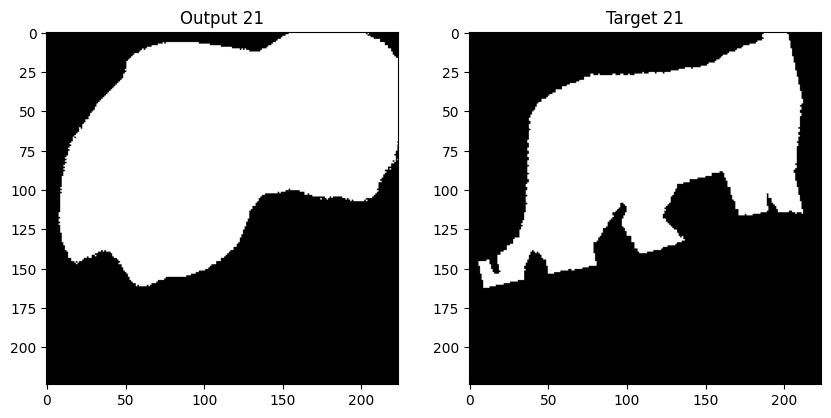

In [880]:
visualitza_resultats()